In [57]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
from natsort import natsorted
from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from statsmodels.tsa.stattools import acf
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.feature import SIFT, match_descriptors,plot_matches
from skimage.feature import ORB

import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from itertools import permutations 
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse

# scan1

In [58]:
# # path = 'human_eye/scan1/'
# path = 'volume_data/OK1_V1_2023_2_7/scan13/'
# pic_paths = []
# for i in os.listdir(path):
#     if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
#         pic_paths.append(i)
# pic_paths = np.array(natsorted(pic_paths))[range(0,len(pic_paths),1)]
# # pic_paths = np.array(natsorted(pic_paths))
# pics_without_line = []


# for i in tqdm(pic_paths):
#     aa = dicom.dcmread(path+i).pixel_array
#     pics_without_line.append(aa.copy())

# pics_without_line1 = np.array(pics_without_line)[100]
# pics_without_line1 = pics_without_line1.astype(np.float32)

In [59]:
path = 'volume_data/OK1_V2_2023_03_03/scan14/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))[range(0,len(pic_paths),1)]
# pic_paths = np.array(natsorted(pic_paths))
pics_without_line = []


for i in tqdm(pic_paths):
    aa = dicom.dcmread(path+i).pixel_array
    pics_without_line.append(aa.copy())

pics_without_line = np.array(pics_without_line)
pics_without_line = pics_without_line.astype(np.float32)

100%|██████████| 500/500 [00:01<00:00, 406.01it/s]


In [282]:
# pics_without_line = pics_without_line[500:700]

In [283]:
# pics_without_line = (pics_without_line-np.min(pics_without_line))/(np.max(pics_without_line)-np.min(pics_without_line))

In [5]:
def load_data(path_num):
    # if (path_num==0) or (path_num=='before'):
    #     path = 'rgb/before/'
    # elif (path_num==1) or (path_num=='after'):
    #     path = 'rgb/after/'
    # elif (path_num==2) or (path_num=='after_2min'):
    path = f'volume_data/OK1_V2_2023_03_03/registered/{path_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    pics_without_line = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # pics_without_line = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        pics_without_line[i] = aa.copy()
    pics_without_line = pics_without_line.astype(np.float32)
    return pics_without_line

In [40]:
def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1


In [41]:
def get_mask(pic):
    th = threshold_otsu(pic)
    temp = (pic>th)
    temp[800:] = 0
    temp[np.argmax(np.sum(temp, axis=1))-50:np.argmax(np.sum(temp, axis=1))+50] = 0
    area_num = np.argmax(np.sum(temp, axis=1))
    return area_num

In [91]:
np.argmax(pics_without_line[391,400:600,:])

51789

In [92]:
np.unravel_index(np.argmax(pics_without_line[391,400:600,:]),pics_without_line[391,400:600,:].shape)

(124, 81)

# try scripts

In [68]:
# def min_max(data1):
#     if np.all(data1 == data1[0]):
#         return data1
#     else:
#         data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
#         return data1

# def cell_extract(data_batch,n):
#     temp_data = data_batch[400:700].copy()
#     ccrds = []
#     # x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
#     # ccrds.append((x_rm,y_rm))
#     for _ in range(n):
#         x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
#         if x_rm<40:
#             x_rm = 0
#         if y_rm<40:
#             y_rm = 0
#         temp_data[x_rm-40:x_rm+40,y_rm-40:y_rm+40] = 0
#         ccrds.append([x_rm,y_rm])
#     ccrds = np.array(ccrds)
#     ccrds[ccrds<40] = 40
#     return ccrds

# def compare_masks(masks_extracted,data_3_n,data_3_i):
#     errs = []
#     for i in range(masks_extracted.shape[0]):
#         rr = masks_extracted[i]
#         metrics = phase_cross_correlation(data_3_n[400:700][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
#                                             data_3_i[400:700][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
#                                             normalization=None,upsample_factor=20)
#         errs.append(metrics[2])
#     errs_idx = np.argmin(np.abs(np.array(errs)))
#     # print(errs_idx)
#     return masks_extracted[errs_idx]
    

# def div3(data):
#     for i in tqdm(range(0,data.shape[0],3)):
#         data[i:i+3] = phase(data[i:i+3])

#     for i in tqdm(range(3,data.shape[0],3)):
#         data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
#     return data

# def phase(data,dis=False):
#     n = data.shape[0]//2
#     for i in range(data.shape[0]):
#         coords = phase_cross_correlation(data[n][400:700]
#                                         ,data[i][400:700]
#                                         ,normalization=None,upsample_factor=20)[0]
#         data[i] = scp.shift(data[i],shift = (coords[0],coords[1]),mode='constant',order=3)
#     return data

# def phase_join_chunks(first,second):
#     coords = phase_cross_correlation(first[-1][400:700]
#                                     ,second[0][400:700]
#                                     ,normalization=None,upsample_factor=20)[0]
#     for i in range(len(second)):
#         second[i] = scp.shift(second[i],shift = (coords[0],coords[1]),mode='constant',order=3)
#     return second


# def div3_reg_optz(data):
#     for i in tqdm(range(0,data.shape[0],3)):
#         data[i:i+3] = man_reg(data[i:i+3])

#     for i in tqdm(range(3,data.shape[0],3)):
#         data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
#     return data    

# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(shif[0],shif[1]))
#     warped = warp(x, tform,order=3)
#     # return -nmi(y,warped)
#     return mse(y,warped)

# def upsamp(data,n):
#     data = pyramid_expand(data,upscale=n,mode='constant', cval=0,order=3)
#     return data

# def downsamp(data,n):
#     data = pyramid_reduce(data,downscale=n,mode='constant', cval=0,order=3)
#     return data

# def man_reg(data):
#     n = data.shape[0]//2
#     get_masks = cell_extract(data[1],4)
    
#     for i in range(data.shape[0]):
#         if i!=n:
#             best_mask = compare_masks(get_masks,data[n],data[i])
#             for pyr in [6]*5:
#                 move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
#                         args = (upsamp((data[i][400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)
#                                 ,upsamp((data[n][400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)))['x'])/pyr
#                 tform2 = AffineTransform(translation=(move[0],move[1]))
                
#                 # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
#                 data[i] = warp(data[i], tform2,order=3)
#             # print('done')
#     return data

# def man_join_chunks(first,second):
#     get_masks = cell_extract(first[-1],4)
#     best_mask = compare_masks(get_masks,first[-1],second[0])
#     for pyr in [6]*5:
#         temp = second[0].copy()
#         move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
#                     args = (upsamp((temp[400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)
#                             ,upsamp((first[-1][400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)))['x'])/pyr
#         tform3 = AffineTransform(translation=(move[0],move[1]))
#         temp = warp(temp, tform3,order=3)
#     for i in range(len(second)):
#         second[i] = warp(second[i], tform3,order=3)
#     return second

In [69]:
# def deq_man_reg(data):
#     for i in tqdm(range(data.shape[0]-1)):
#         get_masks = cell_extract(data[i+1],3)
#         best_mask = compare_masks(get_masks,data[i+1],data[i])
#         for pyr in [4]*4:
#             move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
#                     args = (upsamp((data[i][400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)
#                             ,upsamp((data[i+1][400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)))['x'])/pyr
#             tform2 = AffineTransform(translation=(move[0],move[1]))
#             data[i] = warp(data[i], tform2,order=3)
#         if i!=0:
#             for j in range(data[:i].shape[0]):
#                 data[j] = warp(data[j], tform2,order=3)
#     # get_masks = cell_extract(data[-1],3)
#     # best_mask = compare_masks(get_masks,first[-1],second[0])
#     # for pyr in [6]*5:
#     #     temp = second[0].copy()
#     #     move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
#     #                 args = (upsamp((temp[400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)
#     #                         ,upsamp((first[-1][400:700][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)))['x'])/pyr
#     #     tform3 = AffineTransform(translation=(move[0],move[1]))
#     #     temp = warp(temp, tform3,order=3)
    
#     return data

In [13]:
# def min_max(data1):
#     if np.all(data1 == data1[0]):
#         return data1
#     else:
#         data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
#         return data1

# # def cell_extract(data_batch,n):
# #     temp_data = data_batch[150:300].copy()
# #     ccrds = []
# #     # x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
# #     # ccrds.append((x_rm,y_rm))
# #     for _ in range(n):
# #         x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
# #         if x_rm<40:
# #             x_rm = 0
# #         if y_rm<40:
# #             y_rm = 0
# #         temp_data[x_rm-40:x_rm+40,y_rm-40:y_rm+40] = 0
# #         ccrds.append([x_rm,y_rm])
# #     ccrds = np.array(ccrds)
# #     ccrds[ccrds<40] = 40
# #     return ccrds

# # def compare_masks(masks_extracted,data_3_n,data_3_i):
# #     errs = []
# #     for i in range(masks_extracted.shape[0]):
# #         rr = masks_extracted[i]
# #         metrics = phase_cross_correlation(data_3_n[150:300][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
# #                                             data_3_i[150:300][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
# #                                             normalization=None,upsample_factor=20)
# #         errs.append(metrics[2])
# #     errs_idx = np.argmin(np.abs(np.array(errs)))
# #     # print(errs_idx)
# #     return masks_extracted[errs_idx]
    

# def div3(data):
#     for i in tqdm(range(0,data.shape[0],3)):
#         data[i:i+3] = phase(data[i:i+3])

#     for i in tqdm(range(3,data.shape[0],3)):
#         data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
#     return data

# def phase(data,dis=False):
#     n = data.shape[0]//2
#     for i in range(data.shape[0]):
#         coords = phase_cross_correlation(data[n][150:300]
#                                         ,data[i][150:300]
#                                         ,normalization=None,upsample_factor=20)[0]
#         data[i] = scp.shift(data[i],shift = (coords[0],coords[1]),mode='constant',order=3)
#     return data

# def phase_join_chunks(first,second):
#     coords = phase_cross_correlation(first[-1][150:300]
#                                     ,second[0][150:300]
#                                     ,normalization=None,upsample_factor=20)[0]
#     for i in range(len(second)):
#         second[i] = scp.shift(second[i],shift = (coords[0],coords[1]),mode='constant',order=3)
#     return second


# def div3_reg_optz(data):
#     for i in tqdm(range(0,data.shape[0],3)):
#         data[i:i+3] = man_reg(data[i:i+3])

#     for i in tqdm(range(3,data.shape[0],3)):
#         data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
#     return data    

# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(shif[0],shif[1]))
#     warped = warp(x, tform,order=3)
#     return -nmi(y,warped)
#     # return mse(y,warped)

# def upsamp(data,n):
#     data = pyramid_expand(data,upscale=n,mode='constant', cval=0,order=3)
#     return data

# def downsamp(data,n):
#     data = pyramid_reduce(data,downscale=n,mode='constant', cval=0,order=3)
#     return data

# def samp(data,n):
#     if n>1:
#         return upsamp(data,n)
#     if n<1:
#         return downsamp(data,np.abs(math.log(n,2)*2))
#     if n==1:
#         return data

# def man_reg(data):
#     n = data.shape[0]//2
#     # get_masks = cell_extract(data[1],4)
#     for i in range(data.shape[0]):
#         if i!=n:
#             # best_mask = compare_masks(get_masks,data[n],data[i])
#             for pyr in [0.5,1,2,2,4,4]:
#                 move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
#                         args = (samp((data[i][150:300]),pyr)
#                                 ,samp((data[n][150:300]),pyr)))['x'])/pyr
#                 tform2 = AffineTransform(translation=(move[0],move[1]))
                
#                 # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
#                 data[i] = warp(data[i], tform2,order=3)
#             # print('done')
#     return data

# def man_join_chunks(first,second):
#     # get_masks = cell_extract(first[-1],4)
#     # best_mask = compare_masks(get_masks,first[-1],second[0])
#     for pyr in [2]*3:
#         temp = second[0].copy()
#         move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
#                     args = (samp((temp[150:300]),pyr)
#                             ,samp((first[-1][150:300]),pyr)))['x'])/pyr
#         tform3 = AffineTransform(translation=(move[0],move[1]))
#         temp = warp(temp, tform3,order=3)
#     for i in range(len(second)):
#         second[i] = warp(second[i], tform3,order=3)
#     return second

# cont

In [60]:
def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

# def cell_extract(data_batch,n):
#     temp_data = data_batch[150:300].copy()
#     ccrds = []
#     # x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
#     # ccrds.append((x_rm,y_rm))
#     for _ in range(n):
#         x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
#         if x_rm<40:
#             x_rm = 0
#         if y_rm<40:
#             y_rm = 0
#         temp_data[x_rm-40:x_rm+40,y_rm-40:y_rm+40] = 0
#         ccrds.append([x_rm,y_rm])
#     ccrds = np.array(ccrds)
#     ccrds[ccrds<40] = 40
#     return ccrds

# def compare_masks(masks_extracted,data_3_n,data_3_i):
#     errs = []
#     for i in range(masks_extracted.shape[0]):
#         rr = masks_extracted[i]
#         metrics = phase_cross_correlation(data_3_n[150:300][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
#                                             data_3_i[150:300][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
#                                             normalization=None,upsample_factor=20)
#         errs.append(metrics[2])
#     errs_idx = np.argmin(np.abs(np.array(errs)))
#     # print(errs_idx)
#     return masks_extracted[errs_idx]
    

def div3(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = phase(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
    return data

def phase(data,dis=False):
    n = data.shape[0]//2
    for i in range(data.shape[0]):
        coords = phase_cross_correlation(data[n][150:300]
                                        ,data[i][150:300]
                                        ,normalization=None,upsample_factor=20)[0]
        data[i] = scp.shift(data[i],shift = (coords[0],0),mode='constant',order=3)
    return data

def phase_join_chunks(first,second):
    coords = phase_cross_correlation(first[-1][150:300]
                                    ,second[0][150:300]
                                    ,normalization=None,upsample_factor=20)[0]
    for i in range(len(second)):
        second[i] = scp.shift(second[i],shift = (coords[0],0),mode='constant',order=3)
    return second


def div3_reg_optz(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = man_reg(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
    return data    

def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)
    # return mse(y,warped)

def upsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_expand(temp_data,upscale=n,mode='constant', cval=0,order=3)
    return temp_data

def downsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_reduce(temp_data,downscale=n,mode='constant', cval=0,order=3)
    return temp_data

def samp(data,n):
    if n>1:
        return upsamp(data,n)
    if n<1:
        return downsamp(data,np.abs(math.log(n,2)*2))
    if n==1:
        return data

def man_reg(data):
    n = data.shape[0]//2
    # get_masks = cell_extract(data[1],4)
    for i in range(data.shape[0]):
        tform2 = AffineTransform(translation=(0,0))
        if i!=n:
            # best_mask = compare_masks(get_masks,data[n],data[i])
            temp_i_data = data[i].copy()
            for pyr in [0.5,1,2,2,4,4]:
                move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (samp((temp_i_data[150:300,100:200]),pyr)
                                ,samp((data[n][150:300,100:200]),pyr)))['x'])/pyr
                temp_transform = AffineTransform(translation=(0,move[0]))
                temp_i_data = warp(temp_i_data, temp_transform,order=3)
                tform2 = np.dot(tform2,temp_transform)
                # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
            tform2 = AffineTransform(matrix = tform2)
            data[i] = warp(data[i], tform2,order=3)
            # print('done')
    return data

def man_join_chunks(first,second):
    # get_masks = cell_extract(first[-1],4)
    # best_mask = compare_masks(get_masks,first[-1],second[0])
    tform3 = AffineTransform(translation=(0,0))
    temp = second[0].copy()
    for pyr in [2]*3:
        move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                    args = (samp((temp[150:300,100:200]),pyr)
                            ,samp((first[-1][150:300,100:200]),pyr)))['x'])/pyr
        temp_transform = AffineTransform(translation=(0,move[0]))
        temp = warp(temp, temp_transform,order=3)
        tform3 = np.dot(tform3,temp_transform)
    tform3 = AffineTransform(matrix = tform3)
    for i in range(len(second)):
        second[i] = warp(second[i], tform3,order=3)
    return second

In [142]:
# pics_without_line = deq_man_reg(pics_without_line)

In [61]:
pics_without_line[:,:720] = div3(pics_without_line[:,:720])

100%|██████████| 166/166 [00:13<00:00, 12.68it/s]


In [62]:
pics_without_line[:,:720] = div3_reg_optz(pics_without_line[:,:720])

100%|██████████| 166/166 [01:33<00:00,  1.77it/s]


In [68]:
def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

def cell_extract(data_batch,n):
    temp_data = data_batch[270:470].copy()
    ccrds = []
    for _ in range(n):
        x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
        if x_rm<40:
            x_rm = 40
        if y_rm<40:
            y_rm = 40
        temp_data[x_rm-40:x_rm+40,y_rm-40:y_rm+40] = 0
        ccrds.append([x_rm,y_rm])
    ccrds = np.array(ccrds)
    ccrds[ccrds<40] = 40
    return ccrds

def compare_masks(masks_extracted,data_3_n,data_3_i):
    errs = []
    for i in range(masks_extracted.shape[0]):
        rr = masks_extracted[i]
        metrics = phase_cross_correlation(data_3_n[270:470][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
                                            data_3_i[270:470][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
                                            normalization=None,upsample_factor=20)
        errs.append(metrics[2])
    errs_idx = np.argmin(np.abs(np.array(errs)))
    return masks_extracted[errs_idx]
    

def div3(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = phase(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
    return data

def phase(data,dis=False):
    n = data.shape[0]//2
    for i in range(data.shape[0]):
        coords = phase_cross_correlation(data[n][270:470]
                                        ,data[i][270:470]
                                        ,normalization=None,upsample_factor=20)[0]
        data[i] = scp.shift(data[i],shift = (0,coords[1]),mode='constant',order=3)
    return data

def phase_join_chunks(first,second):
    coords = phase_cross_correlation(first[-1][270:470]
                                    ,second[0][270:470]
                                    ,normalization=None,upsample_factor=20)[0]
    for i in range(len(second)):
        second[i] = scp.shift(second[i],shift = (0,coords[1]),mode='constant',order=3)
    return second


def div3_reg_optz(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = man_reg(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
    return data    

def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],0))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)
    # return mse(y,warped)

def upsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_expand(temp_data,upscale=n,mode='constant', cval=0,order=3)
    return temp_data

def downsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_reduce(temp_data,downscale=n,mode='constant', cval=0,order=3)
    return temp_data

def samp(data,n):
    if n>1:
        return upsamp(data,n)
    if n<1:
        return downsamp(data,np.abs(math.log(n,2)*2))
    if n==1:
        return data

def man_reg(data):
    n = data.shape[0]//2
    get_masks = cell_extract(data[1],4)
    for i in range(data.shape[0]):
        tform2 = AffineTransform(translation=(0,0))
        if i!=n:
            temp_i_data = data[i].copy()
            best_mask = compare_masks(get_masks,data[n],temp_i_data)
            for pyr in [4]*5:
                move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (samp((temp_i_data[270:470][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)
                                ,samp((data[n][270:470][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)))['x'])/pyr
                temp_transform = AffineTransform(translation=(move[0],0))
                temp_i_data = warp(temp_i_data, temp_transform,order=3)
                tform2 = np.dot(tform2,temp_transform)
                # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
            tform2 = AffineTransform(matrix = tform2)
            data[i] = warp(data[i], tform2,order=3)
            # print('done')
    return data

def man_join_chunks(first,second):
    get_masks = cell_extract(first[-1],4)
    best_mask = compare_masks(get_masks,first[-1],second[0])
    tform3 = AffineTransform(translation=(0,0))
    temp = second[0].copy()
    for pyr in [4]*3:
        move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                    args = (samp((temp[270:470][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)
                            ,samp((first[-1][270:470][best_mask[0]-40:best_mask[0]+40,best_mask[1]-40:best_mask[1]+40]),pyr)))['x'])/pyr
        temp_transform = AffineTransform(translation=(move[0],0))
        tform3 = np.dot(tform3,temp_transform)
        temp = warp(temp, temp_transform,order=3)
    tform3 = AffineTransform(matrix = tform3)
    for i in range(len(second)):
        second[i] = warp(second[i], tform3,order=3)
    return second

In [163]:
gg = pics_without_line.copy()

In [164]:
# for i in tqdm(range(gg.shape[0]-1)):
#     coords = phase_cross_correlation(gg[i][270:470]
#                                     ,gg[i+1][270:470]
#                                     ,normalization=None,upsample_factor=5)[0]
#     tfo = AffineTransform(translation=(coords[1],0)).inverse
#     for k in range(i+1,gg.shape[0]):
#         gg[k] = warp(gg[k],tfo,order=3)                              
#     # gg[i:] = scp.shift(gg[i:],shift = (0,coords[1]),mode='constant',order=3)

In [171]:
def to_shape(a, shape):
    ys, xs = shape
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant')

In [278]:
ccs = cell_extract(gg[220],3)[1]

In [279]:
tt = np.zeros_like(gg[220][270:470])
tt[ccs[0]-40:ccs[0]+40,ccs[1]-40:ccs[1]+40] = gg[220][270:470][ccs[0]-40:ccs[0]+40,ccs[1]-40:ccs[1]+40]
# pdtt = to_shape(tt,gg[218][270:470].shape)

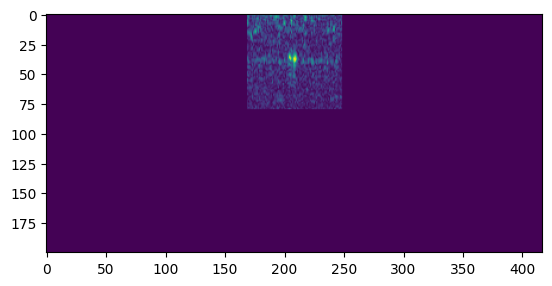

In [280]:
plt.imshow(tt)

In [274]:
kk = phase_cross_correlation(gg[219][270:470],tt,normalization=None)[0]
phase_cross_correlation(gg[219][270:470],tt,normalization=None)

(array([ 0., -1.], dtype=float32), 0.9504608887018018, -6.957401e-08)

In [277]:
-nmi(warp(tt,AffineTransform(translation=(kk[1],0)).inverse)[ccs[0]-40:ccs[0]+40,ccs[1]-40:ccs[1]+40],
    gg[219][270:470][ccs[0]-40:ccs[0]+40,ccs[1]-40:ccs[1]+40])

-1.0389798100578138

In [281]:
-nmi(warp(tt,AffineTransform(translation=(kk[1],0)).inverse)[ccs[0]-40:ccs[0]+40,ccs[1]-40:ccs[1]+40],
    gg[219][270:470][ccs[0]-40:ccs[0]+40,ccs[1]-40:ccs[1]+40])

-1.0306817204431682

In [244]:
kk

array([ 0., -1.], dtype=float32)

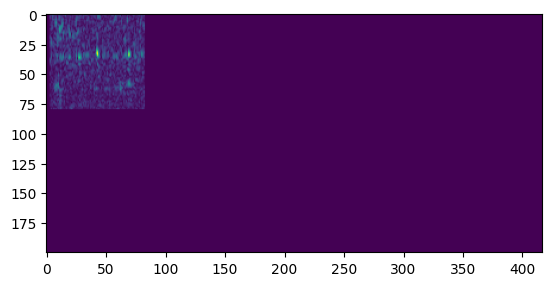

In [245]:
plt.imshow(warp(tt,AffineTransform(translation=(kk[1],0)).inverse))

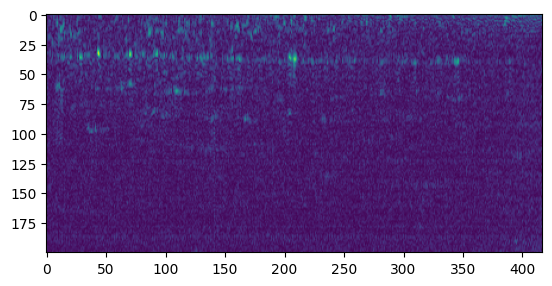

In [246]:
plt.imshow(gg[220][270:470])

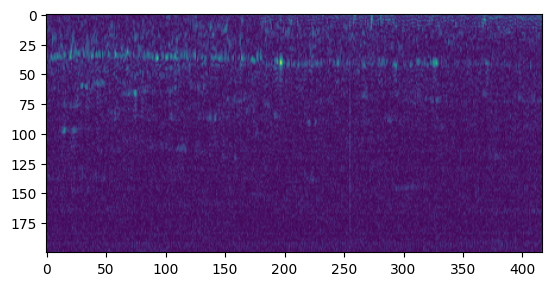

In [220]:
plt.imshow(gg[219][270:470])

In [65]:
gg = div3(gg)

100%|██████████| 166/166 [00:21<00:00,  7.56it/s]


In [20]:
scan12 = div3_reg_optz(scan12)

100%|██████████| 166/166 [02:44<00:00,  1.01it/s]


In [13]:
del pics_without_line

In [39]:
# yy = pics_without_line[388]
tform = AffineTransform(translation=(1,0))
tform2 = AffineTransform(translation=(0,1))
# warped = warp(pics_without_line[388], tform,order=3)

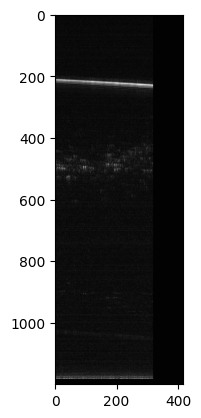

In [64]:
plt.imshow(warped,cmap='gray')

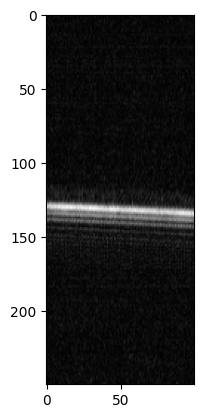

In [9]:
plt.imshow(pics_without_line[388,100:350,100:200],cmap='gray')

In [521]:
og_data = pics_without_line.copy()

In [6]:
for i in tqdm(range(pics_without_line.shape[0])):
    n = np.argmax((np.sum(pics_without_line[i][:700],axis=1)))
    pics_without_line[i][n-50:n+50,:] = pics_without_line[i][:100]
    pics_without_line[i][700:] = 0

# for i in tqdm(range(pics_without_line.shape[0])):
#     # n = np.argmax((np.sum(pics_without_line[i][:800],axis=1)))
#     pics_without_line[i] = np.where(pics_without_line[i]>threshold_otsu(pics_without_line[i]),1,0)


100%|██████████| 2400/2400 [00:00<00:00, 4258.22it/s]


In [168]:
mm = []
for i in tqdm(range(pics_without_line.shape[0]-1)):
    detector_extractor1 = SIFT()
    detector_extractor2 = SIFT()
    detector_extractor1.detect_and_extract(pics_without_line[i][400:600])
    detector_extractor2.detect_and_extract(pics_without_line[i+1][400:600])
    matches = match_descriptors(detector_extractor1.descriptors,
                            detector_extractor2.descriptors,
                            max_ratio=0.6)
    mm.append(matches.shape)

100%|██████████| 2399/2399 [27:17<00:00,  1.47it/s]


In [6]:
gg = pics_without_line.copy()[:,400:600,:]

In [7]:
for i in tqdm(range(len(gg))):
    gg[i] = min_max(gg[i])

100%|██████████| 500/500 [00:00<00:00, 5228.54it/s]


In [8]:
gg.shape

(500, 200, 417)

In [11]:
bool_arr = np.abs(mm2)<10
i=0
j=0
# count = 0
while i<np.abs(mm2).shape[0]-2:
    print(i,j)
    curr_break = j+np.argmin(bool_arr[j:])
    if np.all(bool_arr[j:]):
        curr_break = np.abs(mm2).shape[0]-2
    # for k in range(pics_without_line[i:curr_break+1]):
    pics_without_line[i:curr_break+1] = div3(pics_without_line[i:curr_break+1])
    j = curr_break+np.argmax(bool_arr[curr_break:])
    i=j

0 0


31 31
208 208
451 451
552 552
688 688
691 691
829 829
1054 1054
1057 1057
1224 1224
1378 1378
1643 1643
1645 1645
1761 1761
1913 1913
2227 2227


In [6]:
pics_without_line = div3(pics_without_line)
pics_without_line = div3_reg_optz(pics_without_line)

100%|██████████| 166/166 [05:00<00:00,  1.81s/it]


In [92]:
detector_extractor1 = ORB(n_keypoints=5)
detector_extractor2 = ORB(n_keypoints=5)
detector_extractor1.detect_and_extract(pics_without_line[400,400:600])
detector_extractor2.detect_and_extract(pics_without_line[401,400:600])
matches = match_descriptors(detector_extractor1.descriptors,
                            detector_extractor2.descriptors)


In [381]:
from skimage.feature import SIFT, match_descriptors,plot_matches

detector_extractor1 = SIFT()
detector_extractor2 = SIFT()
detector_extractor1.detect_and_extract(pics_without_line[25][400:600])
detector_extractor2.detect_and_extract(pics_without_line[26][400:600])

In [382]:
matches = match_descriptors(detector_extractor1.descriptors,
                            detector_extractor2.descriptors,
                            max_ratio=0.6)

In [342]:

mm=[]
for i in tqdm(range(pics_without_line.shape[0]-1)):
    detector_extractor1 = SIFT()
    detector_extractor1.detect_and_extract(pics_without_line[i][400:600])
    detector_extractor2 = SIFT()
    detector_extractor2.detect_and_extract(pics_without_line[i+1][400:600])
    matches = match_descriptors(detector_extractor1.descriptors,
                            detector_extractor2.descriptors,
                            max_ratio=0.6)
    mm.append(matches.shape[0])

100%|██████████| 2399/2399 [27:57<00:00,  1.43it/s] 


In [192]:
mm = []
for i in tqdm(range(gg.shape[0]-1)):
    sf = phase_cross_correlation(gg[i],gg[i+1],normalization=None,upsample_factor=20)[0]
    if np.any(np.abs(sf)>1):
        mm.append(False)
    else:
        mm.append(True)

100%|██████████| 1898/1898 [00:38<00:00, 49.33it/s]


In [176]:
mm = []
for i in tqdm(range(gg.shape[0]-1)):
    mm.append(phase_cross_correlation(gg[i],gg[i+1],normalization=None,upsample_factor=20)[0])

100%|██████████| 1406/1406 [00:27<00:00, 51.14it/s]


In [525]:
# for n in tqdm(range(0,data_scan1.shape[0],10)):
#     data_scan1[n:n+10] = man_reg(data_scan1[n:n+10])

# for n in tqdm(range(0,data_scan1.shape[0]-10,10)):
#     data_scan1[n+10:n+20] = man_join_chunks(data_scan1[:n+10],data_scan1[n+10:n+20])

In [526]:
def phase_og(old,data,dis=False):
    n = data.shape[0]//2
    # data_n = get_mask(data[n])
    for i in tqdm(range(data.shape[0]),disable=dis):
        # data_i = get_mask(data[i])
        coords = phase_cross_correlation(data[n][400:600],data[i][400:600],normalization=None,upsample_factor=20)[0]
        old[i] = scp.shift(old[i],shift = (coords[0],coords[1]),mode='constant',order=3)
    return old

In [527]:
# data_scan1 = phase(data_scan1)
# for n in tqdm(range(0,data_scan1.shape[0],10)):
#     data_scan1[n:n+10] = phase(data_scan1[n:n+10],dis=True)

for n in tqdm(range(0,og_data.shape[0],10)):
    og_data[n:n+10] = phase_og(og_data[n:n+10],data_scan1[n:n+10],dis=True)

100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


In [178]:
# for n in tqdm(range(0,data_scan1.shape[0]-5,5)):
#     data_scan1[n+5:n+10] = phase_join_chunks(data_scan1[:n+5],data_scan1[n+5:n+10])

100%|██████████| 39/39 [00:08<00:00,  4.56it/s]


In [25]:
mm = []
for i in tqdm(range(gg.shape[0]-1)):
    mm.append(np.abs(np.argmax(np.sum(gg[i][:400,300:],axis=1)) - np.argmax(np.sum(gg[i+1][:400,300:],axis=1))))
mm.append(0)

100%|██████████| 2399/2399 [00:00<00:00, 3064.08it/s]


In [64]:
gg_idx = np.arange(len(mm))

In [74]:
for i in np.where(np.array(mm)>5):
    for j in range(-3,3,1):
        gg_idx[i+j] = -1

In [87]:
new_mm = []
for i in tqdm(range(gg.shape[0]-1)):
    new_mm.append(np.abs(np.argmax(np.sum(gg[i][:400,300:],axis=1)) - np.argmax(np.sum(gg[i+1][:400,300:],axis=1))))
new_mm.append(0)

100%|██████████| 2040/2040 [00:00<00:00, 4213.04it/s]


In [89]:
img_dict = {}
i = 0
j = 0
curr_i = 0
for i in tqdm(range(len(mm))):
    if mm[i]>5:
        img_dict[j] = gg[curr_i:i]
        j+=1
        curr_i = i
        


100%|██████████| 2400/2400 [00:00<00:00, 1867593.62it/s]


In [103]:

for k, v in list(img_dict.items()):
    if v.shape[0] < 10:
        del img_dict[k]

In [12]:
threshold_otsu(pics_without_line[146][400:600])
gg= pics_without_line[146][400:600].copy()
gg[gg<threshold_otsu(pics_without_line[146][400:600])] = 0

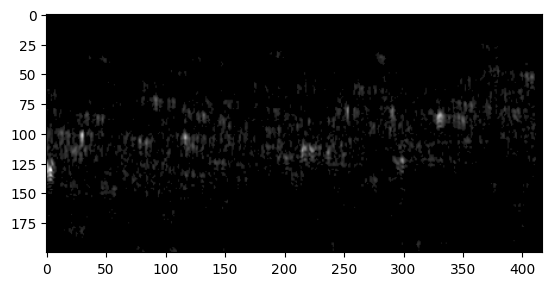

In [14]:
plt.imshow(gg,cmap='gray')

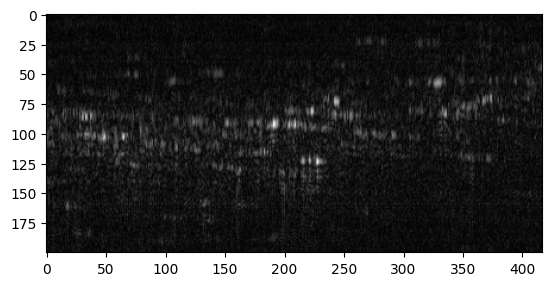

In [337]:
plt.imshow(gg[145],cmap='gray')

In [269]:
import scipy as sp

In [339]:
phase_cross_correlation(gg[145],gg[146],normalization='phase')

(array([-1., -1.], dtype=float32), 0.9999999946532583, 7.3129898e-09)

In [292]:
c = np.abs((fft2(pics_without_line[28][400:600]))).flatten()
d = np.abs((fft2(pics_without_line[29][400:600]))).flatten()
c = min_max(c)
d = min_max(d)

In [293]:
np.correlate(c,d)

array([1.7202975], dtype=float32)

In [275]:
np.correlate(np.abs(fftshift(fft2(pics_without_line[35][400:600]))).flatten(),np.abs(fftshift(fft2(pics_without_line[36][400:600]))).flatten())

array([1.4107386e+12], dtype=float32)

In [283]:
np.correlate(np.abs((fft2(pics_without_line[25][400:600]))).flatten(),np.abs((fft2(pics_without_line[25][400:600]))).flatten())

array([1.699475e+12], dtype=float32)

In [8]:
# for i in tqdm(range(pics_without_line.shape[0])):
#     pics_without_line[i] = min_max(pics_without_line[i])

100%|██████████| 2400/2400 [00:03<00:00, 616.89it/s]


In [127]:
# os.mkdir('volume_data/OK1_V2_2023_03_03/registered/')
# os.mkdir('volume_data/OK1_V2_2023_03_03/registered/scan12/')
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite('volume_data/OK1_V2_2023_03_03/test/'+f'frame_test{i}.PNG',(j))

500it [00:03, 157.64it/s]


# Ploltting

In [70]:
a = np.ones((10,10))
b = np.ones((10,10))
a[3:5,4:6] = 2
b[3:5,5:7] = 2

In [102]:
phase_cross_correlation(a,b,normalization=None,upsample_factor=1)[0]

array([ 0., -1.])

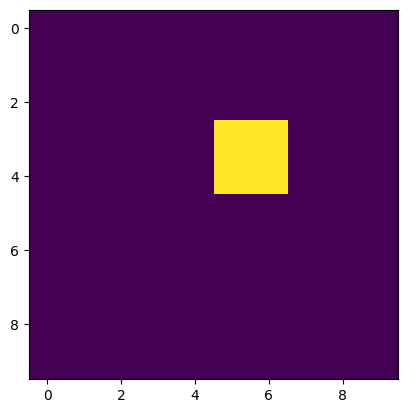

In [109]:
plt.imshow(b)

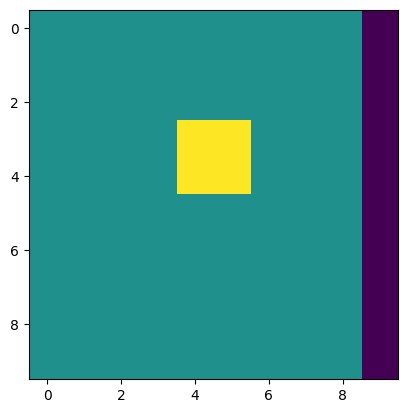

In [110]:
plt.imshow(warp(b,AffineTransform(translation=(-1,0)).inverse,order=3))

In [453]:
cc = phase_cross_correlation(a,b,normalization=None,upsample_factor=1)[0]
tf = AffineTransform(translation=(cc[1],cc[0]))

b_copy = warp(b,tf,order=3)

In [29]:
def mse_try(shif,x,y):
    tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)
    # return mse(y,warped)

In [751]:
from skimage.filters import median as med

In [8]:

# scan14_unreg = pics_without_line.copy()
# scan14 = load_data('scan14')
# scan15_unreg = pics_without_line.copy()
# scan15 = load_data('scan15')


# scan1_unreg = pics_without_line.copy()
# scan1 = load_data('scan1')
# scan12_unreg = pics_without_line.copy()
# scan12 = load_data('scan12')

In [19]:
image1_unreg = np.mean(scan1_unreg.transpose(1,0,2)[260:285],axis=0).copy()
image2_unreg  = np.mean(scan12_unreg.transpose(1,0,2)[270:285],axis=0).copy()
image1 = np.mean(scan1.transpose(1,0,2)[250:270],axis=0).copy()
image2 = np.mean(scan12.transpose(1,0,2)[250:270],axis=0).copy()


# image1_unreg = np.mean(scan14_unreg.transpose(1,0,2)[295:310],axis=0).copy()
# image2_unreg  = np.mean(scan15_unreg.transpose(1,0,2)[285:305],axis=0).copy()
# image1 = np.mean(scan14.transpose(1,0,2)[295:310],axis=0).copy()
# image2 = np.mean(scan15.transpose(1,0,2)[285:305],axis=0).copy()

In [313]:
def cell_extract_nerve(data_batch,n):
    temp_data = data_batch.copy()
    ccrds = []
    for _ in range(n):
        x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
        if x_rm<40:
            x_rm = 40
        if y_rm<40:
            y_rm = 40
        temp_data[x_rm-40:x_rm+40,y_rm-40:y_rm+40] = 0
        ccrds.append([x_rm,y_rm])
    ccrds = np.array(ccrds)
    ccrds[ccrds<40] = 40
    return ccrds

def compare_masks_nerve(masks_extracted,data_3_n,data_3_i):
    errs = []
    for i in range(masks_extracted.shape[0]):
        rr = masks_extracted[i]
        metrics = phase_cross_correlation(data_3_n[rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
                                            data_3_i[rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
                                            normalization=None,upsample_factor=20)
        errs.append(metrics[2])
    print(np.abs(np.array(errs)))
    errs_idx = np.argmin(np.abs(np.array(errs)))
    return masks_extracted[errs_idx]
    

In [21]:
# cc = phase_cross_correlation(image2[170:220,:300],image1[170:220,:300],normalization=None,upsample_factor=20)[0]
# tf = AffineTransform(translation=(cc[1],cc[0]))

# image2_copy = warp(image2,tf,order=3)


cc = phase_cross_correlation(image2,image1,normalization=None,upsample_factor=20)[0]
tf = AffineTransform(translation=(cc[1],cc[0]))

image2_copy = warp(image2,tf,order=3)

In [22]:
cc

array([0., 0.], dtype=float32)

In [23]:
outs = compare_masks_nerve(cell_extract_nerve(image2_copy[170:220,:300],4),image2_copy[170:220,:300],image1[170:220,:300])

NameError: name 'compare_masks_nerve' is not defined

In [24]:
outs

NameError: name 'outs' is not defined

In [30]:
# temp = AffineTransform(translation=(0,0))
# temp_img = image2_copy[170:220,:300].copy()
# for pyr in tqdm([2,2,2,2]):
#         # cc1 = (minz(method='powell',fun = mse_try,x0 =(0,0),
#         #         args = (samp((temp_img[outs[0]-40:outs[0]+40,outs[1]-40:outs[1]+40]),pyr)
#         #         ,samp((image1[outs[0]-40:outs[0]+40,outs[1]-40:outs[1]+40]),pyr)))['x'])/pyr
#         cc1 = (minz(method='powell',fun = mse_try,x0 =(0,0),
#                 args = (samp((temp_img),pyr)
#                 ,samp((image1[170:220,:300]),pyr)))['x'])/pyr
#         temp = np.dot(temp,AffineTransform(translation=(cc1[0],cc1[1])))
#         temp_img = warp(temp_img,AffineTransform(translation=(cc1[0],cc1[1])),order=3)

# tf1 = AffineTransform(matrix=temp)
# image2_copy = warp(image2_copy,tf1,order=3)

temp = AffineTransform(translation=(0,0))
temp_img = image2_copy.copy()
for pyr in tqdm([2,2,2,2]):
        # cc1 = (minz(method='powell',fun = mse_try,x0 =(0,0),
        #         args = (samp((temp_img[outs[0]-40:outs[0]+40,outs[1]-40:outs[1]+40]),pyr)
        #         ,samp((image1[outs[0]-40:outs[0]+40,outs[1]-40:outs[1]+40]),pyr)))['x'])/pyr
        cc1 = (minz(method='powell',fun = mse_try,x0 =(0,0),
                args = (samp((temp_img),pyr)
                ,samp((image1),pyr)))['x'])/pyr
        temp = np.dot(temp,AffineTransform(translation=(cc1[0],cc1[1])))
        temp_img = warp(temp_img,AffineTransform(translation=(cc1[0],cc1[1])),order=3)

tf1 = AffineTransform(matrix=temp)
image2_copy = warp(image2_copy,tf1,order=3)

100%|██████████| 4/4 [00:21<00:00,  5.37s/it]


In [31]:
tf1

<AffineTransform(matrix=
    [[ 1.00000000e+00,  0.00000000e+00, -2.25704153e-06],
     [ 0.00000000e+00,  1.00000000e+00,  3.13869502e-11],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x1796d9fd0>

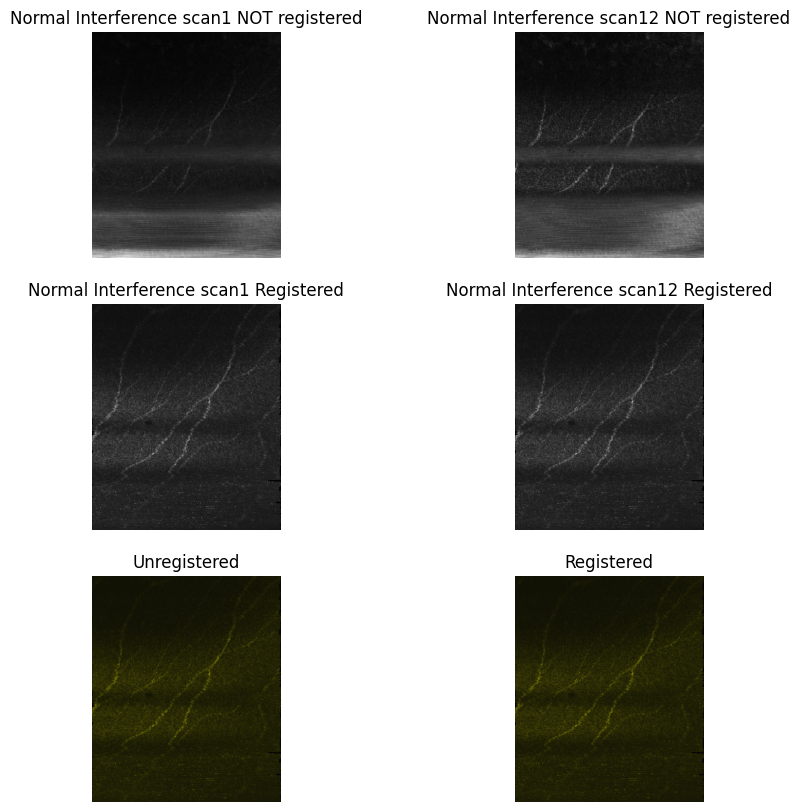

In [33]:

# 

image1_color = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
image1_color[:, :, 0] = image1 # Assign grayscale to the red channel

# # Color the second image in green channel
image2_color = np.zeros((image2_copy.shape[0], image2_copy.shape[1], 3), dtype=np.uint8)
image2_color[:, :, 1] = image2_copy  # Assign grayscale to the green channel

image2_unreg_color = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
image2_unreg_color[:, :, 1] = image2  # Assign grayscale to the green channel

# # Step 3: Overlay the images using weighted addition
# overlay = cv2.addWeighted(image1_color, 2, image2_color, 2, 0.5)

# Step 4: Display the images
# plt.figure(figsize=(8, 8))
fig = plt.figure(figsize=(10, 10))
# plt.title('Overlay of Two Images with Different Colors')
ax1 = fig.add_subplot(3,2,1)
ax1.set_title('Normal Interference scan1 NOT registered')
ax1.imshow(image1_unreg,cmap='gray')

ax2 = fig.add_subplot(3,2,2)
ax2.set_title('Normal Interference scan12 NOT registered')
ax2.imshow(image2_unreg,cmap='gray')

ax3 = fig.add_subplot(3,2,3)
ax3.set_title('Normal Interference scan1 Registered')
ax3.imshow(image1,cmap='gray')

ax4 = fig.add_subplot(3,2,4)
ax4.set_title('Normal Interference scan12 Registered')
ax4.imshow(image2,cmap='gray')

ax5 = fig.add_subplot(3,2,5)
ax5.set_title('Unregistered')
ax5.imshow(cv2.addWeighted(image1_color, 2, image2_unreg_color, 2, 5).astype(np.uint8))

ax6 = fig.add_subplot(3,2,6)
ax6.set_title('Registered')
ax6.imshow(cv2.addWeighted(image1_color, 2, image2_color, 2, 5).astype(np.uint8))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')

# fig.savefig('scan1_12_nerves.png',dpi=500)
plt.show()

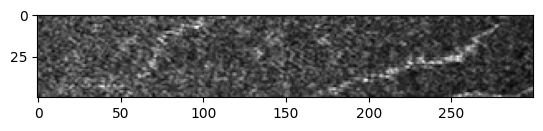

In [321]:
plt.imshow(image2_copy[170:220,:300],cmap='gray')

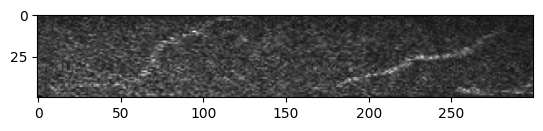

In [322]:
plt.imshow(image1[170:220,:300],cmap='gray')

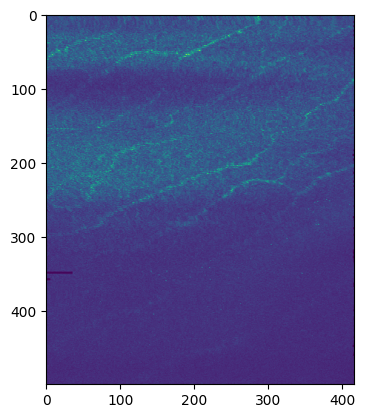

In [343]:
# plt.imshow(np.mean(scan14.transpose(1,0,2)[1114:1121],axis=0))
plt.imshow(np.sum(scan15.transpose(1,0,2)[280:310],axis=0))

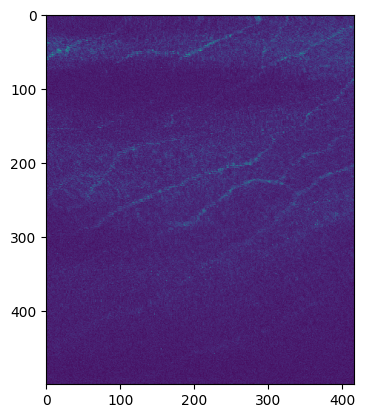

In [205]:
plt.imshow(np.mean(pics_without_line.transpose(1,0,2)[1111:1121],axis=0))